# KMV model

1. Estimate MV and volatility of firm's asset
2. Calulate distance to default and index measure of default risk
3. Scale distance to default to actual probabilities of default using a default database

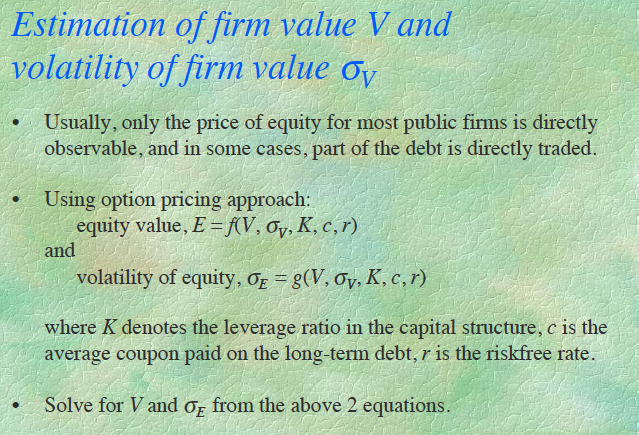

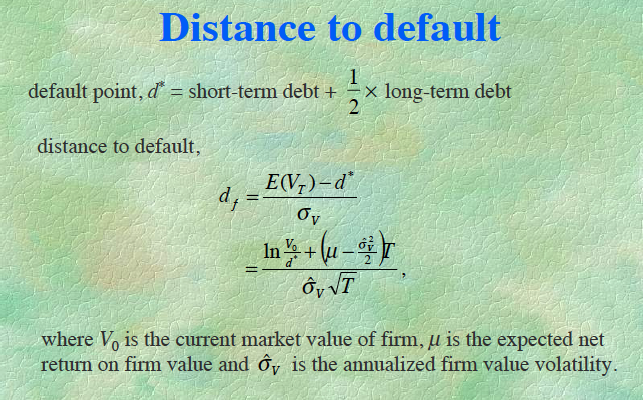

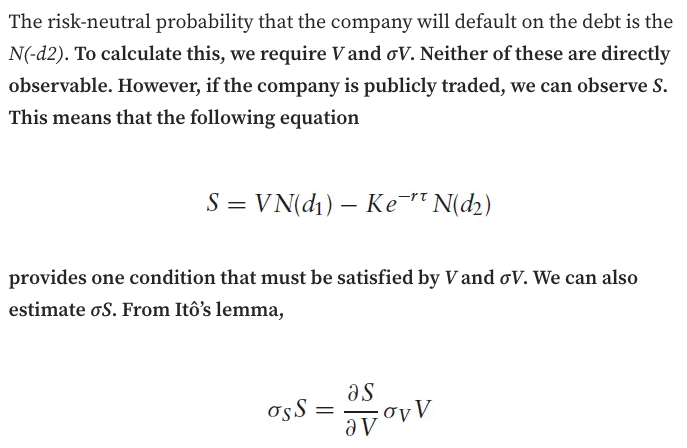

In [41]:
import numpy as np
import math
import pandas as pd
import yfinance as yf
from financetoolkit import Toolkit
from scipy.optimize import minimize
from scipy.stats import norm

np.seterr(divide='ignore', invalid='ignore')

#get data
stockinfo = Toolkit('ROOT', api_key="0265080a2d6590ff848ec3cc090c3ecb")
firmdata = stockinfo.get_enterprise()
BS = stockinfo.get_balance_sheet_statement()
price = stockinfo.get_historical_data(start='2022-01-01', end='2023-01-01', period = 'monthly')['Adj Close']
T = 1
r = 0.0543 #1 year risk free rate

years = BS.columns
shares = firmdata['Number of Shares'][-1:][years[-1]]
MV = price * shares

asset = BS[years[-1]]['Total Assets']
LTD = BS[years[-1]]['Long Term Debt']
STD = BS[years[-1]]['Short Term Debt']
DPT = STD + 0.5* LTD #default point

<ipython-input-41-c2b4d7c2d624>:12: DeprecationWarning: This version of the Finance Toolkit is depreciated. Finance Toolkit 1.0.3 and onwards require Python 3.10 and higher. Please update to the latest version of Python and the Finance Toolkit.
  stockinfo = Toolkit('ROOT', api_key="0265080a2d6590ff848ec3cc090c3ecb")


# Implied Asset Value

In [42]:
def merton_equity_fv(r, S, K, T, sigma, type='C'):    
    d1 = (np.log(S/K) + (r+ 0.5 * sigma**2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type == 'C':
        price = S*norm.cdf(d1,0,1) - K*np.exp(-r*T)*norm.cdf(d2,0,1)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2,0,1) - S*norm.cdf(-d1,0,1)
    return price

def objfunc(*par):
    diff = (merton_equity_fv(r,par[0],DPT,T,sigma,'C') - MV[i])**2
    return diff

sigma = MV.pct_change()[1:].std()* np.sqrt(12)
implied_asset = []
for i in range(len(MV)):
    res = minimize(objfunc, [asset])
    implied_asset.append(res.x[0])

In [43]:
returns = pd.DataFrame(implied_asset).pct_change()[1:]
equity_mu = returns.mean() * 12
equity_vol = returns.std() * np.sqrt(12)

dtd = (np.log(implied_asset[-1]/DPT) + (equity_mu - 0.5* equity_vol**2)*T)/(equity_vol * np.sqrt(T))
default_p = norm.cdf(-dtd,0,1)
default_p[0]

0.9811055949379544